# TP3
### Équipe 10
### Fabrice Charbonneau (1798064)
### Sanou Armel Kenzanga Landry (1976804)


1. créer une matrice termes-documents; pour diminuer la taille du vocabulaire, utiliser un stemmer et éliminer les chiffres et la ponctuation;
2. transformer les fréquences brutes par les valeurs TF-IDF;
3. effectuer une réduction de dimensions avec SVD; utilisez 50 dimensions latentes.



D'abord, lire les fichiers et les ajouter à un dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import PlaintextCorpusReader
from os import path

#can be removed
from jupyterthemes import jtplot
jtplot.style()

In [2]:
if not path.exists("raw_data.csv"):
    i = 0
    df = pd.DataFrame(columns=['uni', 'course', 'text'])
    class_data = 'Descriptions' 
    corpus = PlaintextCorpusReader(class_data, '.*txt', encoding='latin-1')
    for file in corpus.fileids():
        uni_str = file.split("/")[0]
        new_corpus = PlaintextCorpusReader(class_data, file, encoding='latin-1')
        df.loc[i] = [uni_str, file.split("/")[1].split(".")[0], new_corpus.raw()]
        i += 1
        print(i,  end='\r')
    df.to_csv("raw_data.csv", index=False)

In [3]:
df = pd.read_csv("raw_data.csv")

Détection du langage des textes avec https://pypi.org/project/langdetect/

Nous n'allons conserver que les cours ayant comme langage détecté le français.

In [4]:
from langdetect import detect

if not path.exists("fr_only.csv"):
    df["lang"] = df.apply( lambda row: detect(row["text"]), axis=1)
    df = df[df["lang"] == "fr"]
    df.to_csv("fr_only.csv", index=False)
df = pd.read_csv("fr_only.csv")

In [5]:
df = df.drop(columns="lang")

In [6]:
df

,Unnamed: 0,uni,course,text
0,0,HEC,1-404-96,TitreCours: Sociologie de l\nDescriptionCours:...
1,1,HEC,1-407-00,TitreCours: Management\nDescriptionCours: Ce c...
2,3,HEC,1-611-09,TitreCours: Modelisation et optimisation\nDesc...
3,4,HEC,1-611-96,TitreCours: Modelisation et optimisation\nDesc...
4,5,HEC,1-612-96,TitreCours: Mathematiques financieres\nDescrip...
...,...,...,...,...
16050,16330,UdM,VNM1060H,TitreCours: Vietnamien elementaire 2\nDescript...
16051,16331,UdM,VNM2050,TitreCours: Vietnamien intermediaire 1\nDescri...
16052,16332,UdM,VNM2050H,TitreCours: Vietnamien intermediaire 1\nDescri...
16053,16333,UdM,VNM2060,TitreCours: Vietnamien intermediaire 2\nDescri...


Utilisation d'un Tokenizer pour séparer les strings en mots.

TweetTokenizer de nltk est à la base fait pour les tweets, donc traite le texte pouvant contenir des hashtags et autres particularité des tweets. Dans notre cas, ça ne change pas grand chose, il fera facilement le travail même le texte n'est pas des tweets.

In [7]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tokens = df["text"].apply(lambda x: tknzr.tokenize(x)).values

Stemmer afin d'éliminer les tokens inutles

In [8]:
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.corpus import stopwords

In [9]:
st = SnowballStemmer("french", ignore_stopwords=True)
[st.stem(word) for word in ["Yeux", "Sociologie", ".", "souris"]]

['yeux', 'sociolog', '.', 'sour']

In [10]:
class Preprocessor:
    def __init__(self, stem=True, punctuation=True, digit=True):
        self.st = SnowballStemmer("french", ignore_stopwords=True)
        self.punctuations = set(string.punctuation)
        self.stem = stem
        self.punctuation = punctuation
        self.digit = digit
    
    def raw_preprocess(self, token_list):
        new_token_list = []
        for token in token_list:
            is_token_valid = True
            token = token.lower()
            
            # stemming
            if self.stem:
                token = self.st.stem(token)

            # punctuation filtering
            if self.punctuation and token in self.punctuations:
                is_token_valid = False

            # digit filtering
            elif self.digit and token.isdigit():
                is_token_valid = False

            # add token to new sub list
            if is_token_valid:
                new_token_list.append(token)
        return new_token_list
        
    def preprocess_tokens(self, tokens):
        new_tokens = []
        for token_list in tokens:
            new_tokens.append(self.raw_preprocess(token_list))
        return new_tokens
    
def preprocess(tokens):
    preprocessor = Preprocessor()
    return preprocessor.preprocess_tokens(test)

In [11]:
test = [
    ['Sociologie', 'de', 'l', 'DescriptionCours', ':', 'Trois', 'volets', 'principaux', 'dans', 'ce', 'cours'],
    ['Management', 'DescriptionCours', ':', 'Ce', 'cours', 'est', 'une', 'introduction', 'au', 'management', 'et']
]
preprocessor = Preprocessor()
preproc_test = preprocessor.preprocess_tokens(test)
preproc_test

[['sociolog',
  'de',
  'l',
  'descriptioncour',
  'trois',
  'volet',
  'principal',
  'dans',
  'ce',
  'cour'],
 ['manag',
  'descriptioncour',
  'ce',
  'cour',
  'est',
  'une',
  'introduct',
  'au',
  'manag',
  'et']]

TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(preprocessor=preprocessor.raw_preprocess ,tokenizer=identity_tokenizer)
IDF_data = vectorizer.fit_transform(tokens)

SVD

In [13]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, algorithm='randomized', n_iter=100)
svd.fit(IDF_data)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=100,
             random_state=None, tol=0.0)

In [14]:
sum(svd.explained_variance_)

0.183732935169068

In [15]:
SVD_data = svd.transform(IDF_data)

## 1. Quels sont les 10 cours les plus similaires à LOG2420 dans l'espace réduit à 50 dimensions? (8 pts.) Prenez le cosinus comme mesure de similarité. 

In [16]:
LOG2420_idx = df.index[df["course"] == 'LOG2420'][0]

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(SVD_data)

In [18]:
log_2420_cos = cos_matrix[LOG2420_idx]
log_2420_sorted_cos = np.sort(log_2420_cos)
recommendations_cos = log_2420_sorted_cos[::-1][1:11] #[::-1] reverses the list, and [1:11] takes the 10 firsts ignoring the very first one which is the course itself

In [19]:
recommendations_indexes = [np.where(log_2420_cos == reco)[0][0] for reco in recommendations_cos]

In [20]:
df.loc[list(recommendations_indexes)]

,Unnamed: 0,uni,course,text
1669,1888,Poly,LOG1000,TitreCours: Ingenierie logicielle\nDescription...
1585,1804,Poly,INF1005C,TitreCours: Programmation procedurale\nDescrip...
1584,1803,Poly,INF1005B,TitreCours: Programmation procedurale\nDescrip...
1583,1802,Poly,INF1005A,TitreCours: Programmation procedurale\nDescrip...
1660,1879,Poly,INF8701,TitreCours: Simulation des systemes a evenem. ...
967,1186,Poly,AE4500,TitreCours: Informatique embarque\nDescription...
1670,1889,Poly,LOG2410,TitreCours: Conception logicielle\nDescription...
1682,1901,Poly,LOG4430,TitreCours: Architecture logicielle et concept...
1552,1771,Poly,IND6402,TitreCours: Interfaces humains-ordinateurs\nDe...
1658,1877,Poly,INF8500,TitreCours: Systemes embarques:conception et v...


## 2. Effectuez une classification de cours par une approche supervisée (4 pts.) Pour établir les libellés de classes, prenez les acronymes de cours commençant par PSY (psychologie) et PHY (physique). Calculez les centroides de chaque classe (PSY et PHY) des données d'entraînement et calculez l'aire sous la courbe ROC pour la prédiction de données de test (AUC, Area Under receiver operator Curve). 

In [21]:
mask = ((df["course"].astype(str).str[:3] == "PSY") | (df["course"].astype(str).str[:3] == "PHY"))
class_df = df[mask]

class_df["PSY"] = df["course"].astype(str).str[:3] == "PSY"
class_df

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,uni,course,text,PSY
7633,7891,UQAM,PHY0350,TitreCours: Introduction a la mecanique genera...,False
7634,7892,UQAM,PHY1011,TitreCours: L\nDescriptionCours: Ce cours s'ad...,False
7635,7893,UQAM,PHY1020,TitreCours: Les systemes physiques\nDescriptio...,False
7636,7894,UQAM,PHY1030,TitreCours: La physique des interactions et de...,False
7637,7895,UQAM,PHY1050,TitreCours: Mecanique\nDescriptionCours: Ce co...,False
...,...,...,...,...,...
15102,15379,UdM,PSY3299,TitreCours: Stage d'initiation a la psychologi...,True
15103,15380,UdM,PSY3952,TitreCours: Psychologie en readaptation\nDescr...,True
15104,15381,UdM,PSY3954,TitreCours: Methodes d'entrevue en sante\nDesc...,True
15105,15382,UdM,PSY4000,TitreCours: Projet de recherche Honor\nDescrip...,True


In [22]:
indexes = list(class_df.index.values)

In [23]:
X_data = []
for index in indexes:
    X_data.append(SVD_data[index])
    
#np.take(SVD_data, indexes)
X_data = np.array(X_data)

In [24]:
y_data = class_df["PSY"].values

In [25]:
len(X_data)

521

In [26]:
len(y_data)

521

In [69]:
n_positives = 0
for y in y_data:
    if y:
        n_positives += 1
n_positives

407

In [70]:
n_positives/len(y_data)

0.781190019193858

tiré de https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci/52910821

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

In [76]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=15)
knn_classifier.fit(X_train, y_train)

y_scores = knn_classifier.predict_proba(X_test)

In [77]:
y_scores[:10]

array([[0.06666667, 0.93333333],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.13333333, 0.86666667],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [0.06666667, 0.93333333],
       [0.4       , 0.6       ]])

In [78]:
y_test[:10]

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True])

On peut déjà voir que le modèle semble bien identifier les cours.

In [79]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)

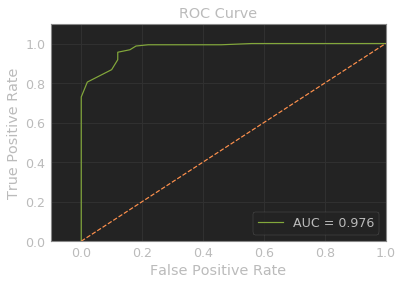

In [80]:
plt.plot(false_positive_rate, true_positive_rate, 'g', label = 'AUC = %0.3f' % roc_auc)
plt.legend()
plt.plot([0, 1], [0, 1], 'y--')
plt.xlim([-0.1, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

## 3. À partir de la validation croisée de la tâche de classification ci-dessus, déterminez le nombre de dimensions latentes optimal de SVD selon une approche dite wrapper (4 pts.).

Nous allons utiliser l'accuracy afin de déterminer si un modèle est meilleur qu'un autre.

Il est à noter que pour effectuer la validation croisée, nous allons utiliser *stratified kfold* puisque la quantité de cours de physique est petite en proportion à celle des cours de psychologie.

In [ ]:
from sklearn.model_selection import StratifiedKFold



## 4.Effectuez une agglomération par k-means (k=2) et vérifiez si les classes PHY et PSY sont bien séparées par cette méthode (4 pts.). (à compléter)